In [1]:
# Imports
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
from arch import arch_model
import statsmodels.api as sm
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, GRU
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping

In [2]:
# Load Table
df = pd.read_csv('google_trends_5yrs.csv',index_col=0)

In [3]:
df.head()

,economics,debt,inflation,metals,sell,bonds,risk,car,leverage,color,...,fun,short selling,earnings,holiday,profit,kitchen,train,ring,conflict,VIX
date,,,,,,,,,,,,,,,,,,,,,
12/9/2018,26,27,12,12,70,2,0,82,0,28,...,14,0,1,25,3,20,49,22,2,21.629999
12/16/2018,20,23,9,10,73,2,0,76,0,26,...,14,0,1,27,2,20,50,20,1,30.110001
12/23/2018,14,18,7,6,74,1,3,81,0,24,...,14,0,1,40,2,20,53,21,1,28.340000
12/30/2018,17,28,8,8,81,2,0,85,0,25,...,14,0,1,27,2,22,50,23,1,21.379999
1/6/2019,24,30,9,10,77,2,0,87,0,26,...,15,0,1,19,3,20,47,20,2,18.190001


In [4]:
features = df.iloc[:, :-1].values
vix = df.iloc[:, -1].values

scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

## Data Processing

In [5]:
# Create sequences for LSTM training
sequence_length = 6
X, y = [], []

for i in range(len(features_scaled) - sequence_length):
    X.append(np.concatenate((features_scaled[i:i + sequence_length, :], vix[i:i + sequence_length].reshape(-1, 1)), axis=1))
    y.append(vix[i + sequence_length])
    
X, y = np.array(X), np.array(y)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [7]:
print("Shapes:")
print("(batch_size, time_steps, seq_len)")
print(f'X_train: {X_train.shape}')
print(f'y_train: {y_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_test: {y_test.shape}')

Shapes:
(batch_size, time_steps, seq_len)
X_train: (203, 6, 99)
y_train: (203,)
X_test: (51, 6, 99)
y_test: (51,)


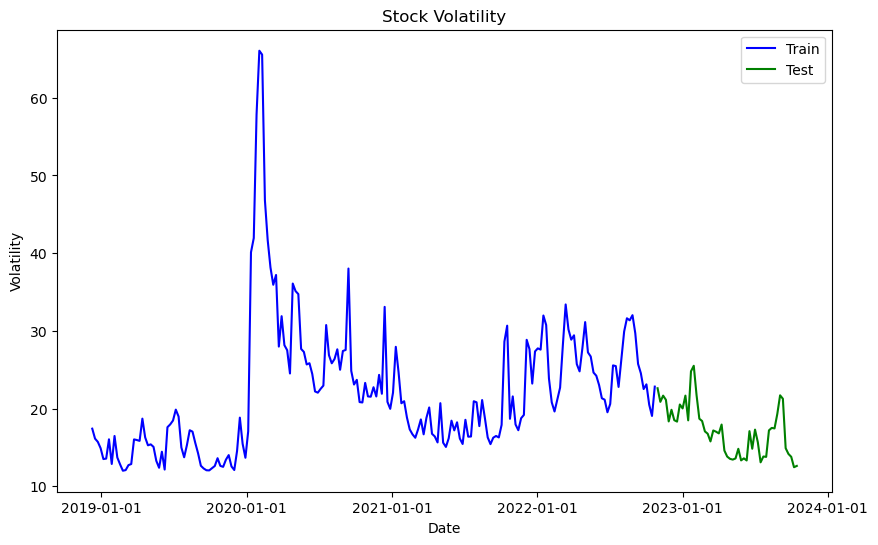

In [8]:
start_date = datetime(2018, 12, 9)
indices_train_dates = [start_date + timedelta(weeks=i) for i in range(len(y_train))]
indices_test_dates = [start_date + timedelta(weeks=i) for i in range(len(y_train), len(y_train) + len(y_test))]

plt.figure(figsize=(10, 6))
plt.plot(indices_train_dates, y_train, label='Train', color='blue')
plt.plot(indices_test_dates, y_test, label='Test', color='green')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.title('Stock Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

## Basic LSTM Model

In [9]:
model = Sequential()
model.add(LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=1, activation='linear'))
model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError(), 'mape'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                41984     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 42049 (164.25 KB)
Trainable params: 42049 (164.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
np.random.seed(123)
tf.random.set_seed(123)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
history = model.fit(X_train, y_train, validation_split=0.3, epochs=1000, batch_size=32, callbacks=[es])

Epoch 1/1000
5/5 [==============================] - 1s 75ms/step - loss: 529.1494 - root_mean_squared_error: 23.0032 - mape: 98.5913 - val_loss: 589.3619 - val_root_mean_squared_error: 24.2768 - val_mape: 97.4384
Epoch 2/1000
5/5 [==============================] - 0s 8ms/step - loss: 502.6781 - root_mean_squared_error: 22.4205 - mape: 94.4786 - val_loss: 558.8497 - val_root_mean_squared_error: 23.6400 - val_mape: 94.5390
Epoch 3/1000
5/5 [==============================] - 0s 7ms/step - loss: 474.8866 - root_mean_squared_error: 21.7919 - mape: 90.0792 - val_loss: 524.7944 - val_root_mean_squared_error: 22.9084 - val_mape: 91.2446
Epoch 4/1000
5/5 [==============================] - 0s 7ms/step - loss: 446.6168 - root_mean_squared_error: 21.1333 - mape: 85.5682 - val_loss: 487.4004 - val_root_mean_squared_error: 22.0771 - val_mape: 87.5696
Epoch 5/1000
5/5 [==============================] - 0s 7ms/step - loss: 418.2216 - root_mean_squared_error: 20.4505 - mape: 81.3159 - val_loss: 450.052

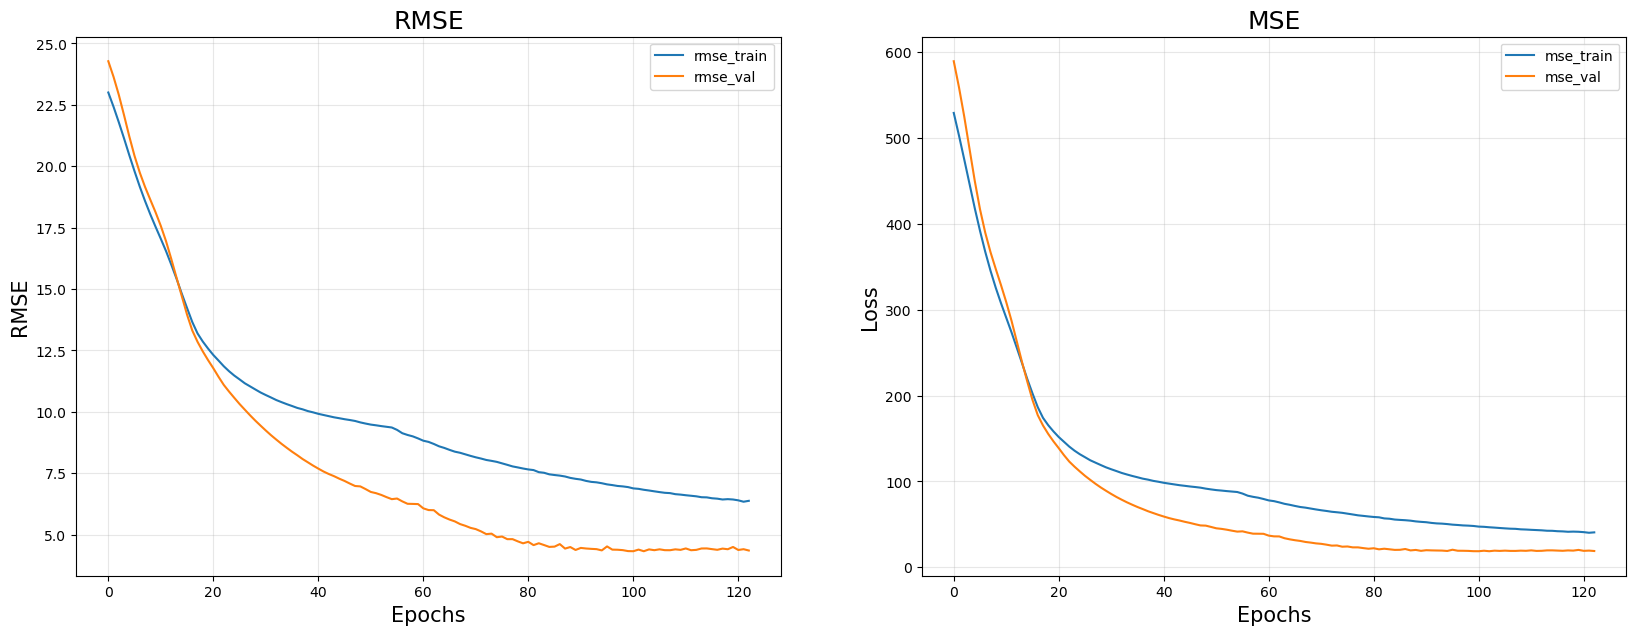

In [11]:
fig = plt.figure(figsize=(20,7))
fig.add_subplot(121)

plt.plot(history.epoch, history.history['root_mean_squared_error'], label = "rmse_train")
plt.plot(history.epoch, history.history['val_root_mean_squared_error'], label = "rmse_val")

plt.title("RMSE", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("RMSE", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

fig.add_subplot(122)

plt.plot(history.epoch, history.history['loss'], label="mse_train")
plt.plot(history.epoch, history.history['val_loss'], label="mse_val")

plt.title("MSE", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()

In [12]:
# Model Evaluation
loss = model.evaluate(X_test, y_test)
print(f'Test MSE: {loss}')

2/2 [==============================] - 0s 4ms/step - loss: 7.0208 - root_mean_squared_error: 2.6497 - mape: 13.7877
Test MSE: [7.020784378051758, 2.6496763229370117, 13.78770923614502]


2/2 [==============================] - 0s 5ms/step


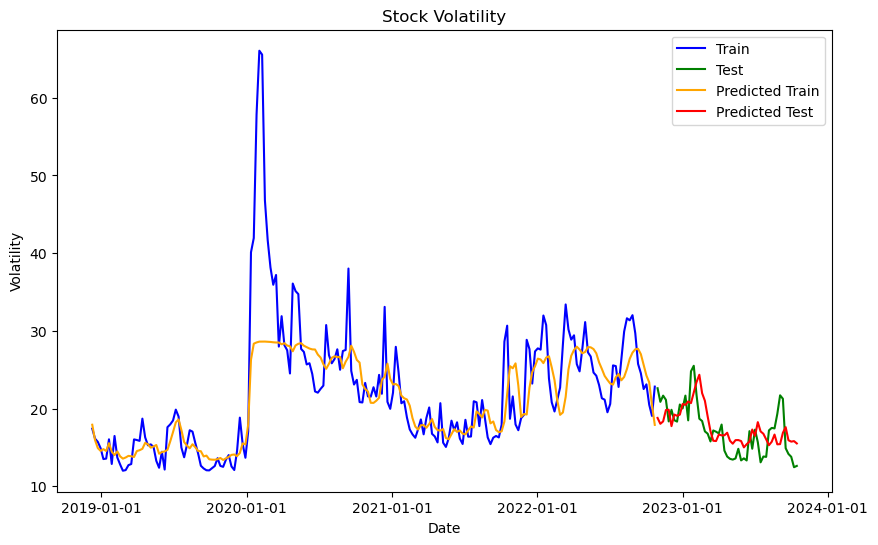

In [13]:
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

start_date = datetime(2018, 12, 9)
indices_train_dates = [start_date + timedelta(weeks=i) for i in range(len(y_train))]
indices_test_dates = [start_date + timedelta(weeks=i) for i in range(len(y_train), len(y_train) + len(y_test))]

plt.figure(figsize=(10, 6))
plt.plot(indices_train_dates, y_train, label='Train', color='blue')
plt.plot(indices_test_dates, y_test, label='Test', color='green')
plt.plot(indices_train_dates, train_predictions, label='Predicted Train', color='orange')
plt.plot(indices_test_dates, test_predictions, label='Predicted Test', color='red')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.title('Stock Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

## PCA + LSTM

In [14]:
from sklearn.decomposition import PCA

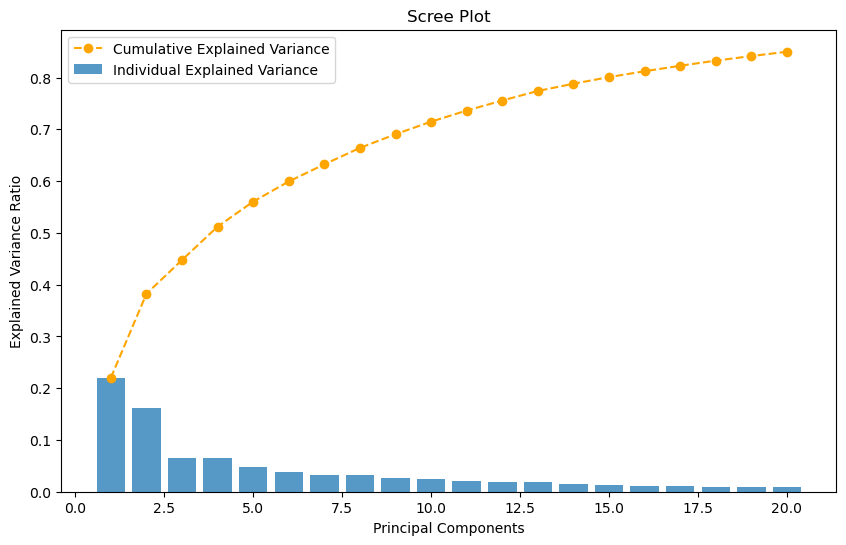

In [15]:
pca = PCA(n_components=20)
pca_fit = pca.fit(features_scaled)

# Scree plot
explained_variance_ratio = pca_fit.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.75, align='center', label='Individual Explained Variance')
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--', color='orange', label='Cumulative Explained Variance')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.legend()
plt.show()

In [16]:
features_pca = pca_fit.transform(features_scaled)

In [17]:
# Create sequences for LSTM training
sequence_length = 6
X, y = [], []

for i in range(len(features_pca) - sequence_length):
    X.append(np.concatenate((features_pca[i:i + sequence_length, :], vix[i:i + sequence_length].reshape(-1, 1)), axis=1))
    y.append(vix[i + sequence_length])
    
X, y = np.array(X), np.array(y)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [19]:
model = Sequential()
model.add(LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=1, activation='linear'))
model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError(), 'mape'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                22016     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 22081 (86.25 KB)
Trainable params: 22081 (86.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
np.random.seed(123)
tf.random.set_seed(123)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
history = model.fit(X_train, y_train, validation_split=0.3, epochs=1000, batch_size=32, callbacks=[es])

Epoch 1/1000
5/5 [==============================] - 2s 94ms/step - loss: 541.9161 - root_mean_squared_error: 23.2791 - mape: 100.0344 - val_loss: 604.0615 - val_root_mean_squared_error: 24.5777 - val_mape: 98.7551
Epoch 2/1000
5/5 [==============================] - 0s 13ms/step - loss: 513.5362 - root_mean_squared_error: 22.6613 - mape: 95.9846 - val_loss: 574.2001 - val_root_mean_squared_error: 23.9625 - val_mape: 95.9904
Epoch 3/1000
5/5 [==============================] - 0s 10ms/step - loss: 485.7344 - root_mean_squared_error: 22.0394 - mape: 91.8709 - val_loss: 543.7328 - val_root_mean_squared_error: 23.3181 - val_mape: 93.1051
Epoch 4/1000
5/5 [==============================] - 0s 13ms/step - loss: 458.1433 - root_mean_squared_error: 21.4043 - mape: 87.6407 - val_loss: 510.0881 - val_root_mean_squared_error: 22.5851 - val_mape: 89.8624
Epoch 5/1000
5/5 [==============================] - 0s 8ms/step - loss: 427.6708 - root_mean_squared_error: 20.6802 - mape: 83.2346 - val_loss: 474

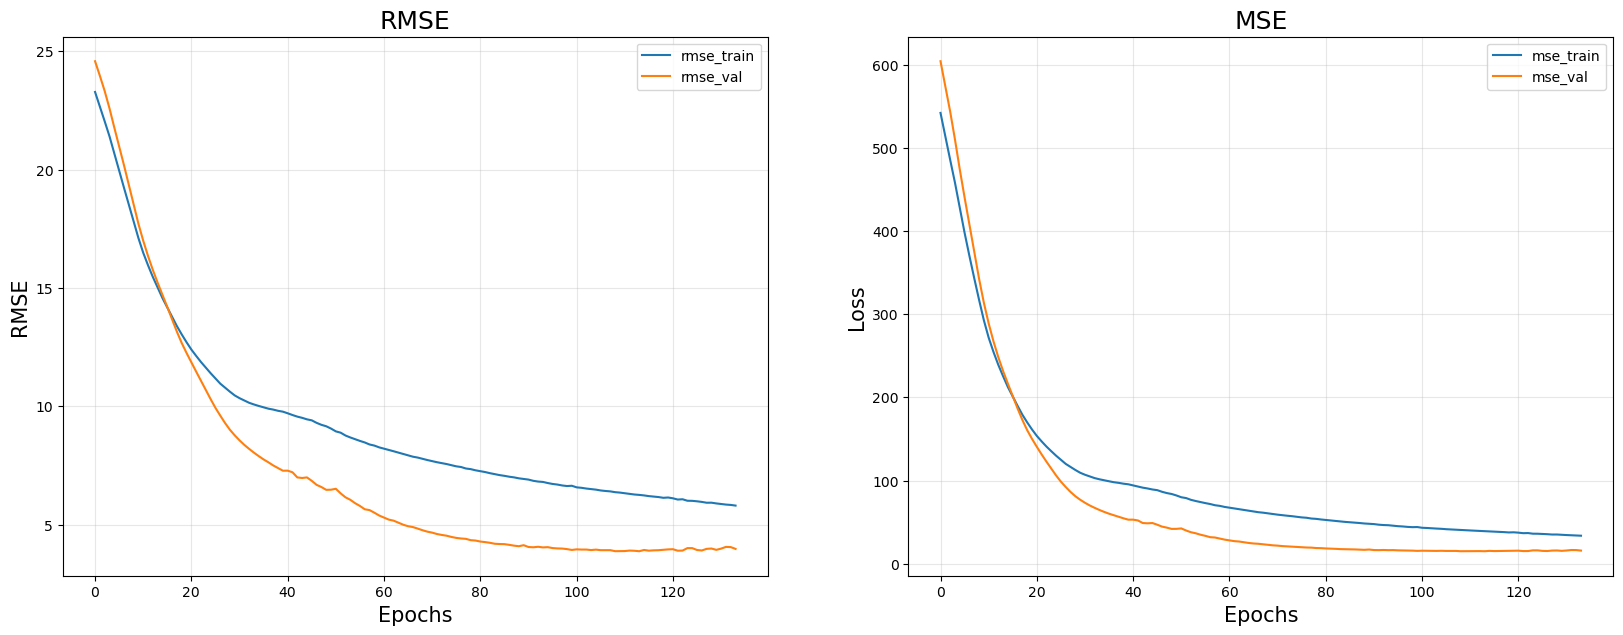

In [21]:
fig = plt.figure(figsize=(20,7))
fig.add_subplot(121)

plt.plot(history.epoch, history.history['root_mean_squared_error'], label = "rmse_train")
plt.plot(history.epoch, history.history['val_root_mean_squared_error'], label = "rmse_val")

plt.title("RMSE", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("RMSE", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

fig.add_subplot(122)

plt.plot(history.epoch, history.history['loss'], label="mse_train")
plt.plot(history.epoch, history.history['val_loss'], label="mse_val")

plt.title("MSE", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()

In [22]:
# Model Evaluation
loss = model.evaluate(X_test, y_test)
print(f'Test MSE: {loss}')

2/2 [==============================] - 0s 3ms/step - loss: 8.8712 - root_mean_squared_error: 2.9785 - mape: 14.1179
Test MSE: [8.871188163757324, 2.9784538745880127, 14.117850303649902]


2/2 [==============================] - 0s 0s/step


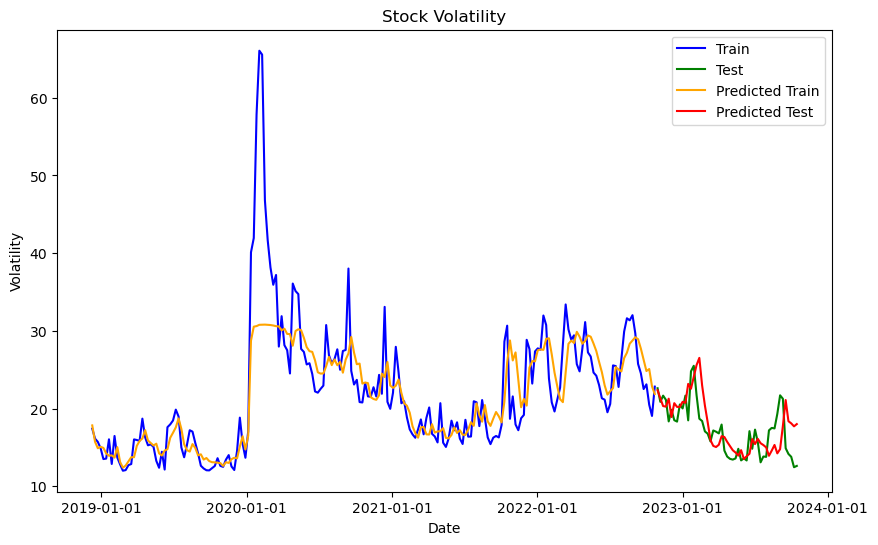

In [23]:
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

start_date = datetime(2018, 12, 9)
indices_train_dates = [start_date + timedelta(weeks=i) for i in range(len(y_train))]
indices_test_dates = [start_date + timedelta(weeks=i) for i in range(len(y_train), len(y_train) + len(y_test))]

plt.figure(figsize=(10, 6))
plt.plot(indices_train_dates, y_train, label='Train', color='blue')
plt.plot(indices_test_dates, y_test, label='Test', color='green')
plt.plot(indices_train_dates, train_predictions, label='Predicted Train', color='orange')
plt.plot(indices_test_dates, test_predictions, label='Predicted Test', color='red')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.title('Stock Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()